In [1]:
import praw
import requests
import pandas as pd
import json
from datetime import datetime, timedelta, date

from config import reddit_client_id
from config import reddit_secret_key
from config import reddit_user_name
from config import reddit_password
from config import yahoo_api_key

import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress

from scipy import stats

In [2]:

yahoo_base_url = "https://yahoo-finance127.p.rapidapi.com/price/"


headers_yahoo = {
    "X-RapidAPI-Key": yahoo_api_key,
    "X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
}


#get input from user for stock symbol
company_names = []
stock_symbol = str(input("Enter stock symbol to search"))


#------------------------------------------------------------------------TO-DO - Add error handling for when ticker is not found

yahoo_response = requests.get(yahoo_base_url + stock_symbol, headers=headers_yahoo).json()
#yahoo_response


#Add longname as search term for reddit
company_names.append(yahoo_response["longName"])

#Add stock symbol as search term for reddit
company_names.append(stock_symbol)

#Get alternate company names to use for reddit search
msg = f"{stock_symbol}'s LongName is {company_names[0]}.  Add another search term and press Enter, or press Cancel when done'"

while True:
    response = str(input(msg))
    if len(response)> 0:
        company_names.append(response)
    else:
        break

#remove duplicates from company_names
reddit_search_list = pd.Series(company_names).drop_duplicates().tolist()

In [3]:
print(yahoo_response)

{'symbol': 'AAPL', 'twoHundredDayAverageChangePercent': {'raw': 0.09557401, 'fmt': '9.56%'}, 'dividendDate': {'raw': 1700092800, 'fmt': '2023-11-15', 'longFmt': '2023-11-15T19:00'}, 'averageAnalystRating': '2.1 - Buy', 'fiftyTwoWeekLowChangePercent': {'raw': 0.5557703, 'fmt': '55.58%'}, 'language': 'en-US', 'dividendYield': {'raw': 0.49, 'fmt': '0.49%'}, 'regularMarketDayRange': {'raw': '191.43 - 193.49', 'fmt': '191.43 - 193.49'}, 'earningsTimestampEnd': {'raw': 1707134400, 'fmt': '2024-02-05', 'longFmt': '2024-02-05T07:00'}, 'epsForward': {'raw': 6.64, 'fmt': '6.64'}, 'regularMarketDayHigh': {'raw': 193.49, 'fmt': '193.49'}, 'twoHundredDayAverageChange': {'raw': 16.85234, 'fmt': '16.85'}, 'askSize': {'raw': 12, 'fmt': '12', 'longFmt': '12'}, 'twoHundredDayAverage': {'raw': 176.32765, 'fmt': '176.33'}, 'bookValue': {'raw': 3.997, 'fmt': '4.00'}, 'marketCap': {'raw': 3004489793536, 'fmt': '3.004T', 'longFmt': '3,004,489,793,536'}, 'fiftyTwoWeekHighChange': {'raw': -5.050003, 'fmt': '-5

In [5]:
#Do reddit search

auth = requests.auth.HTTPBasicAuth(reddit_client_id,reddit_secret_key)
data = {
    'grant_type': 'password',
    'username': reddit_user_name,
    'password': reddit_password
}
headers = {'User-Agent': 'redditapi/1'}
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)
token12 = res.json()['access_token']
headers = {**headers, **{'Authorization': f'bearer {token12}'}}
headers
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

reddit_posts = []
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_secret_key,
    password = data['password'],
    user_agent=f"testscript by u/{data['username']}",
    username = data['username'],
)


#-----------------------------------------------------------TO-DO: Do we need to set a different limit or search criteria?
for term in reddit_search_list:
    for submission in reddit.subreddit("wallstreetbets").search(term, limit=100, sort="new"):
        sub_create_utc = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d') 
        reddit_posts.append({"search term": term,
                             "title": submission.title,
                            "upvotes": submission.score,
                            "num_comments": submission.num_comments,
                            "date_utc": sub_create_utc})
    


reddit_df = pd.DataFrame(reddit_posts)
reddit_df.drop_duplicates(subset=["title"],keep="first",inplace=True)
reddit_df

,search term,title,upvotes,num_comments,date_utc
0,Apple Inc.,What's the verdict on DELL's earnings tonight ...,18,35,2023-11-30
1,Apple Inc.,Small gain today,30,17,2023-11-16
2,Apple Inc.,Apple insiders sold shares worth $88 mln in Oc...,56,20,2023-11-15
3,Apple Inc.,Preliminary DD: ROKU,21,26,2023-10-27
4,Apple Inc.,Apple Plans AirPods Overhaul — New Low- and Hi...,52,35,2023-10-25
...,...,...,...,...,...
294,Apple,You know it’s September,15,6,2023-09-13
295,Apple,"Apple ""Event"" today",12,7,2023-09-12
296,Apple,Is Apple's new $2000 iPhone and USB-C charging...,1055,257,2023-09-12
297,Apple,"Apple's ""Mother Earth"". Cringe.",1515,267,2023-09-12


In [6]:
url = f"https://yahoo-finance127.p.rapidapi.com/historic/{stock_symbol}/1d/100d"

yahoo_response2 = requests.get(url,headers=headers_yahoo).json()
yahoo_response2

{'meta': {'currency': 'USD',
  'symbol': 'AAPL',
  'exchangeName': 'NMS',
  'instrumentType': 'EQUITY',
  'firstTradeDate': 345479400,
  'regularMarketTime': 1702328401,
  'gmtoffset': -18000,
  'timezone': 'EST',
  'exchangeTimezoneName': 'America/New_York',
  'regularMarketPrice': 193.18,
  'chartPreviousClose': 193.13,
  'priceHint': 2,
  'currentTradingPeriod': {'pre': {'timezone': 'EST',
    'start': 1702285200,
    'end': 1702305000,
    'gmtoffset': -18000},
   'regular': {'timezone': 'EST',
    'start': 1702305000,
    'end': 1702328400,
    'gmtoffset': -18000},
   'post': {'timezone': 'EST',
    'start': 1702328400,
    'end': 1702342800,
    'gmtoffset': -18000}},
  'dataGranularity': '1d',
  'range': '100d',
  'validRanges': ['1d',
   '5d',
   '1mo',
   '3mo',
   '6mo',
   '1y',
   '2y',
   '5y',
   '10y',
   'ytd',
   'max']},
 'timestamp': [1689946200,
  1690205400,
  1690291800,
  1690378200,
  1690464600,
  1690551000,
  1690810200,
  1690896600,
  1690983000,
  1691069

In [7]:
yahoo_finance3 = []
x = 0
for date_data in yahoo_response2['timestamp']:
    formatted_date = datetime.utcfromtimestamp(yahoo_response2['timestamp'][x]).strftime('%Y-%m-%d') 
    
    yahoo_finance3.append({"Symbol": yahoo_response2['meta']["symbol"],
                        "date_utc": formatted_date,
                        "Open": yahoo_response2['indicators']['quote'][0]['open'][x],
                        "Volume": yahoo_response2['indicators']['quote'][0]['volume'][x],
                        "High": yahoo_response2['indicators']['quote'][0]['high'][x],
                        "Close": yahoo_response2['indicators']['quote'][0]['close'][x],
                        "Low": yahoo_response2['indicators']['quote'][0]['low'][x]})
    
    x += 1

    



yahoo_finance3_df = pd.DataFrame(yahoo_finance3)


yahoo_finance3_df["Daily Change"] = yahoo_finance3_df["Close"] - yahoo_finance3_df["Open"]
print(yahoo_finance3_df)


   Symbol    date_utc        Open    Volume        High       Close  \
0    AAPL  2023-07-21  194.100006  71917800  194.970001  191.940002   
1    AAPL  2023-07-24  193.410004  45377800  194.910004  192.750000   
2    AAPL  2023-07-25  193.330002  37283200  194.440002  193.619995   
3    AAPL  2023-07-26  193.669998  47471900  195.639999  194.500000   
4    AAPL  2023-07-27  196.020004  47460200  197.199997  193.220001   
..    ...         ...         ...       ...         ...         ...   
95   AAPL  2023-12-05  190.210007  66628400  194.399994  193.419998   
96   AAPL  2023-12-06  194.449997  41089700  194.759995  192.320007   
97   AAPL  2023-12-07  193.630005  47477700  195.000000  194.270004   
98   AAPL  2023-12-08  194.199997  53377300  195.990005  195.710007   
99   AAPL  2023-12-11  193.110001  60896700  193.490005  193.179993   

           Low  Daily Change  
0   191.229996     -2.160004  
1   192.250000     -0.660004  
2   192.919998      0.289993  
3   193.320007      0.8

In [8]:
merged_df = pd.merge(reddit_df,yahoo_finance3_df)
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
0,Apple Inc.,What's the verdict on DELL's earnings tonight ...,18,35,2023-11-30,AAPL,189.839996,48794400,190.320007,189.949997,188.190002,0.110001
1,Apple Inc.,Small gain today,30,17,2023-11-16,AAPL,189.570007,54412900,190.960007,189.710007,188.649994,0.139999
2,Apple Inc.,Apple insiders sold shares worth $88 mln in Oc...,56,20,2023-11-15,AAPL,187.850006,53790500,189.500000,188.009995,187.779999,0.159988
3,AAPL,Calls on Swifties?,49,13,2023-11-15,AAPL,187.850006,53790500,189.500000,188.009995,187.779999,0.159988
4,AAPL,My bad guys. Purchased a put option the other ...,3483,164,2023-11-15,AAPL,187.850006,53790500,189.500000,188.009995,187.779999,0.159988
...,...,...,...,...,...,...,...,...,...,...,...,...
149,Apple,Apple's share price dips again amid growing re...,5460,674,2023-09-27,AAPL,172.619995,66921800,173.039993,170.429993,169.050003,-2.190002
150,Apple,Long lines in India for Iphone 15 and China de...,23,20,2023-09-22,AAPL,174.669998,56725400,177.080002,174.789993,174.050003,0.119995
151,Apple,Thinking about going all in with 5 year long p...,292,287,2023-09-19,AAPL,177.520004,51826900,179.630005,179.070007,177.130005,1.550003
152,Apple,"Down 21k last year, Finally in the Green",207,53,2023-09-19,AAPL,177.520004,51826900,179.630005,179.070007,177.130005,1.550003


In [9]:

merged_df = merged_df[(np.abs(stats.zscore(merged_df['upvotes'])) < 3)]
merged_df = merged_df[(np.abs(stats.zscore(merged_df['num_comments'])) < 3)]
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
0,Apple Inc.,What's the verdict on DELL's earnings tonight ...,18,35,2023-11-30,AAPL,189.839996,48794400,190.320007,189.949997,188.190002,0.110001
1,Apple Inc.,Small gain today,30,17,2023-11-16,AAPL,189.570007,54412900,190.960007,189.710007,188.649994,0.139999
2,Apple Inc.,Apple insiders sold shares worth $88 mln in Oc...,56,20,2023-11-15,AAPL,187.850006,53790500,189.500000,188.009995,187.779999,0.159988
3,AAPL,Calls on Swifties?,49,13,2023-11-15,AAPL,187.850006,53790500,189.500000,188.009995,187.779999,0.159988
4,AAPL,My bad guys. Purchased a put option the other ...,3483,164,2023-11-15,AAPL,187.850006,53790500,189.500000,188.009995,187.779999,0.159988
...,...,...,...,...,...,...,...,...,...,...,...,...
148,Apple,Briefing: Microsoft Reportedly Tried to Sell B...,366,58,2023-09-29,AAPL,172.020004,51814200,173.070007,171.210007,170.339996,-0.809998
150,Apple,Long lines in India for Iphone 15 and China de...,23,20,2023-09-22,AAPL,174.669998,56725400,177.080002,174.789993,174.050003,0.119995
151,Apple,Thinking about going all in with 5 year long p...,292,287,2023-09-19,AAPL,177.520004,51826900,179.630005,179.070007,177.130005,1.550003
152,Apple,"Down 21k last year, Finally in the Green",207,53,2023-09-19,AAPL,177.520004,51826900,179.630005,179.070007,177.130005,1.550003


0      77.946808
1      78.172176
2      78.322346
3      78.322346
4      78.322346
         ...    
148    71.035245
150    78.021893
151    88.764946
152    88.764946
153    88.764946
Name: Daily Change, Length: 149, dtype: float64
7.5125833607845935
y = 7.51x +77.12
The r-value is: 0.02648148688834919


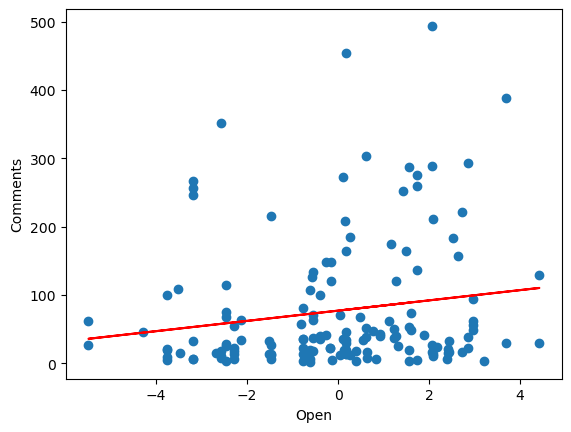

In [12]:
# Linear regression on Reddit upvotes and comments
x_values = merged_df['Daily Change']
y_values = merged_df['num_comments']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept
print(regress_values)
print(slope)

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)
# Create Plot
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")

# Label plot and annotate the line equation
plt.xlabel('Open')
plt.ylabel('Comments')
plt.annotate(line_eq,(20,5),fontsize=15,color="red")

# Print r value
print(f"The r-value is: {rvalue**2}")

# Show plot
plt.show()

In [ ]:

yahoo_finance = []

yahoo_finance.append({"Symbol": yahoo_response["symbol"],
                        "Day_Range_raw": yahoo_response["regularMarketDayRange"]["raw"],
                        "Market_Price": yahoo_response["regularMarketPrice"]["raw"],
                        "Company_Name": yahoo_response["longName"]})

yahoo_finance_df = pd.DataFrame(yahoo_finance)
yahoo_finance_df.head()


,Symbol,Day_Range_raw,Market_Price,Company_Name
0,TSLA,237.4512 - 243.441,239.74,"Tesla, Inc."
